In [1]:
import torch
import torchphysics as tp
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
U = tp.spaces.R1('u')
V = tp.spaces.R1('v')
URMS = tp.spaces.R1('urms')
VRMS = tp.spaces.R1('vrms')
UV=tp.spaces.R1('uv')
P=tp.spaces.R1('p')

/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np

In [3]:
class Turbulent_Data(torch.utils.data.Dataset):
    def __init__(self,data_DF,x_list,y_list):
        self.x_train=data_DF[x_list].values
        self.y_train=data_DF[y_list].values
        #self.x_train=torch.tensor(x_train,dtype=torch.float32)
        #self.y_train=torch.tensor(y_train,dtype=torch.float32)
        #self.x_train=tp.spaces.Points(self.x_train,X*Y)
        #self.y_train=tp.spaces.Points(self.y_train,U*V)
    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        #return self.x_train[idx] , self.y_train[idx]
        #print(torch.as_tensor([self.x_train[idx]]).shape)
        P_xtrain=tp.spaces.Points([self.x_train[idx]],X*Y,dtype=torch.float32)
        P_ytrain=tp.spaces.Points([self.y_train[idx]],U*V*URMS*VRMS*UV,dtype=torch.float32)
        return P_xtrain,P_ytrain

In [4]:
class Ho_Turbulent_Data(torch.utils.data.Dataset):
    def __init__(self,data_DF,x_list,y_list,horizon_sampler):
        self.x_train=data_DF[x_list].values
        self.y_train=data_DF[y_list].values
        self.sampler=horizon_sampler
        #self.x_train=torch.tensor(x_train,dtype=torch.float32)
        #self.y_train=torch.tensor(y_train,dtype=torch.float32)
        #self.x_train=tp.spaces.Points(self.x_train,X*Y)
        #self.y_train=tp.spaces.Points(self.y_train,U*V)
    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        #return self.x_train[idx] , self.y_train[idx]
        #print(torch.as_tensor([self.x_train[idx]]).shape)
        x_horizon= self.sampler.sample_points(device="cpu")
        x_horizon,_=x_horizon.track_coord_gradients()
        x_horizon=x_horizon["x"].detach().numpy()
        #print(x_horizon)
        y_new=np.broadcast_to(self.x_train[idx],(x_horizon.shape[0],self.x_train[idx].shape[0]))
        target_new=np.broadcast_to(self.y_train[idx],(x_horizon.shape[0],self.y_train[idx].shape[0]))
        X_points = np.concatenate((x_horizon,y_new),axis=1)
        P_xtrain=tp.spaces.Points([X_points],X*Y,dtype=torch.float32)
        P_ytrain=tp.spaces.Points([target_new],U*V,dtype=torch.float32)
        return P_xtrain,P_ytrain

In [5]:
class Rn_Turbulent_Data(torch.utils.data.Dataset):
    def __init__(self,data_DF,x_list,y_list,max_it):
        self.x_train=data_DF[x_list].values
        self.y_train=data_DF[y_list].values
        self.length=min(max_it,len(self.y_train))
        #self.x_train=torch.tensor(x_train,dtype=torch.float32)
        #self.y_train=torch.tensor(y_train,dtype=torch.float32)
        #self.x_train=tp.spaces.Points(self.x_train,X*Y)
        #self.y_train=tp.spaces.Points(self.y_train,U*V)
    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        #return self.x_train[idx] , self.y_train[idx]
        #print(torch.as_tensor([self.x_train[idx]]).shape)
        id_random=random.randint(0,len(self.y_train))
        P_xtrain=tp.spaces.Points([self.x_train[id_random]],X*Y,dtype=torch.float32)
        P_ytrain=tp.spaces.Points([self.y_train[id_random]],U*V*URMS*VRMS*UV,dtype=torch.float32)
        return P_xtrain,P_ytrain

In [6]:
DF_Data=pd.read_csv("Data/Flat_Turb_500.csv")

In [7]:
DF=DF_Data#[0::5]

In [8]:
#DF=DF[(DF["y"]<=0.2)|(DF["y"]>=1.8)]

In [9]:
DF

,x,y,U,V,urms,vrms,uv
0,0,0.000000,-7.184000e-16,-2.267000e-35,1.967500e-14,7.751400e-17,4.814100e-35
1,0,0.000031,1.286900e-03,3.593100e-26,5.187100e-04,2.314900e-07,-2.474000e-11
2,0,0.000123,5.147100e-03,6.249800e-25,2.074000e-03,3.681500e-06,-1.590600e-09
3,0,0.000278,1.158000e-02,-1.264700e-24,4.662800e-03,1.842900e-05,-1.823100e-08
4,0,0.000493,2.058300e-02,-3.911600e-24,8.281000e-03,5.731000e-05,-1.033400e-07
...,...,...,...,...,...,...,...
396,0,1.999500,2.049700e-02,7.117400e-24,8.230900e-03,5.700000e-05,1.027000e-07
397,0,1.999700,1.153100e-02,-4.540300e-25,4.634600e-03,1.832800e-05,1.812100e-08
398,0,1.999900,5.125500e-03,2.467800e-25,2.061400e-03,3.661300e-06,1.581000e-09
399,0,2.000000,1.281500e-03,4.035400e-26,5.155700e-04,2.302200e-07,2.459300e-11


In [10]:
import random
def Augment_1D_data(DF,Nsampler,L_x):
    DF_out=DF[0:0]
    for _ in range(Nsampler):
        Ny=random.randint(0, len(DF)-1)
        DF_temp=DF.iloc[[Ny]]
        DF_temp["x"]=random.uniform(0,L_x)
        DF_out=pd.concat([DF_out,DF_temp],ignore_index=True)
    return DF_out

        

In [11]:
torch.cuda.device_count()

0

In [12]:
X_interval = tp.domains.Interval(X, 0, 4.0) # <-add the bounds of the Interval (0, 2)
Y_interval = tp.domains.Interval(Y, -0.2, 2.0)
Sim_domain = X_interval*Y_interval


In [13]:
DF_out=Augment_1D_data(DF_Data,8000,2.0)
ho_sampler = tp.samplers.RandomUniformSampler(X_interval, n_points=200)
dataset_turbulent=Ho_Turbulent_Data(DF,["y"],["U","V"],ho_sampler)

/tmp/ipykernel_1081161/1272658583.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_temp["x"]=random.uniform(0,L_x)


In [14]:

bound_sampler_low = tp.samplers.RandomUniformSampler(Y_interval.boundary_left*X_interval, n_points=250)

bound_sampler_up = tp.samplers.RandomUniformSampler(X_interval*Y_interval.boundary, n_points=500)


In [15]:
def IBM_filter(y):
    return y[...,0]<0
    
IBM_sampler = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter)

In [16]:
def IBM_filter_2(y):
    return (y[...,0]<0)&(y[...,0]>-0.1)
    
IBM_sampler_2 = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter_2)

In [17]:
def Inner_filter(y):
    return y[...,0]>=0

inner_sampler = tp.samplers.RandomUniformSampler(Sim_domain, n_points=3000)#,filter_fn=Inner_filter)

In [18]:
model = tp.models.FCN(input_space=X*Y, output_space=U*V*URMS*VRMS*UV*P, hidden=(64,64,64,64))#######Activation????

In [19]:
data_cond = tp.conditions.DataCondition_mean(model, dataset_turbulent, norm=2.0,root=1.0,weight=500,use_full_dataset=True,name='Data')

In [20]:
inte_sampler = tp.samplers.RandomUniformSampler(X_interval.boundary*Y_interval, n_points=250)
x_inlet_sampler=tp.samplers.RandomUniformSampler(X_interval*Y_interval,n_points=250)

In [21]:
def init_bulk(u_integral):
    return u_integral-1
pde_cond_bulk=tp.conditions.IntegroPINNCondition(model,x_inlet_sampler,init_bulk,inte_sampler, weight=1)

In [22]:
def pde_IBM(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM = tp.conditions.PINNCondition(model, IBM_sampler, pde_IBM,weight=10,name='IBM')

In [23]:
def pde_IBM_2(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM_2 = tp.conditions.PINNCondition(model, IBM_sampler_2, pde_IBM_2,weight=10,name='IBM_2')

In [24]:
def pde_mass(u,v,x,y):
    return tp.utils.grad(u,x)+tp.utils.grad(v,y)-0.0
pde_cond_mass = tp.conditions.PINNCondition(model, inner_sampler,pde_mass, weight=600,name='Conti')

In [25]:
def pde_residual_x(u,v, x, y,urms,vrms,uv,p):
    residual_momentum= u*tp.utils.grad(u,x)+ v*tp.utils.grad(u,y)+(-tp.utils.laplacian(u, x)-tp.utils.laplacian(u,y))/6000 + (1/12)**2+tp.utils.grad(torch.square(urms),x)+tp.utils.grad(uv,y)+tp.utils.grad(p,x)
    return residual_momentum

pde_cond_x = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_x, pde_IBM,weight=600,name='Momentum_x')

In [26]:
def pde_residual_y(u,v, x, y,urms,vrms,uv,p):
    residual_momentum= u*tp.utils.grad(v,x)+v*tp.utils.grad(v,y)+(-tp.utils.laplacian(v, x)-tp.utils.laplacian(v,y))/6000+tp.utils.grad(uv,x)+tp.utils.grad(torch.square(vrms),y)+tp.utils.grad(p,y)
    return residual_momentum

pde_cond_y = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_y, pde_IBM,weight=600,name='Momentum_y')

In [27]:
def boundary_residual_x(u, x,y):
    return torch.square(u) - 0.0

boundary_cond_x = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_x, weight=100,name='noslip_x')

In [28]:
def boundary_residual_y(v, x,y):
    return torch.square(v) - 0.0

boundary_cond_y = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_y, weight=100,name='noslip_y')

In [29]:
def boundary_residual_uu(urms, x,y):
    return torch.square(urms) - 0.0

boundary_cond_uu = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_uu, weight=100,name='noslip_x_uu')

In [30]:
def boundary_residual_vv(vrms, x,y):
    return torch.square(vrms) - 0.0

boundary_cond_vv = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_vv, weight=100,name='noslip_x_vv')

In [31]:
def boundary_residual_uv(uv, x,y):
    return uv - 0.0

boundary_cond_uv = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_uv, weight=100,name='noslip_x_uv')

In [32]:

Periodic_sampler=tp.samplers.RandomUniformSampler(Y_interval,n_points=250)#,filter_fn=Inner_filter)

In [33]:
def periodic_residual_x(u_left,u_right):
    Periodic_condition= u_left - u_right
    return Periodic_condition
periodic_cond_x=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_x,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_x')

In [34]:
def periodic_residual_y(v_left,v_right):
    Periodic_condition= v_left - v_right
    return Periodic_condition
periodic_cond_y=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_y,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_y')

In [35]:
def periodic_residual_uu(urms_left,urms_right):
    Periodic_condition= urms_left - urms_right
    return Periodic_condition
periodic_cond_uu=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_uu,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_uu')

In [36]:
def periodic_residual_vv(vrms_left,vrms_right):
    Periodic_condition= vrms_left - vrms_right
    return Periodic_condition
periodic_cond_vv=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_vv,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_vv')

In [37]:
def periodic_residual_uv(uv_left,uv_right):
    Periodic_condition= uv_left - uv_right
    return Periodic_condition
periodic_cond_uv=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_uv,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_uv')

In [38]:
def periodic_residual_p(p_left,p_right):
    Periodic_condition= p_left-p_right
    return Periodic_condition
periodic_cond_p=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_p,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_p')

In [39]:
bound_sampler_left = tp.samplers.RandomUniformSampler(X_interval.boundary_left*Y_interval, n_points=250)
def boundary_residual_p(p, x,y):
    return p

boundary_cond_p = tp.conditions.PINNCondition(model, bound_sampler_left, boundary_residual_p, weight=1,name='bound_p')

In [40]:
##Learning rate scheduling To-Do -- launch LR scheduling only after first training phase
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001,scheduler_class=torch.optim.lr_scheduler.ReduceLROnPlateau,scheduler_args={"patience":1000,"factor":0.8,"verbose":True,"min_lr":0.000005},monitor_lr="train/loss")
#solver = tp.solver.Solver([pde_cond_IBM,pde_cond_mass,boundary_cond_x, pde_cond_x,periodic_cond_x,boundary_cond_y, pde_cond_y,periodic_cond_y], optimizer_setting=optim)
##loss terms scheduling
solver = tp.solver.Solver([pde_cond_IBM,#1000
                           pde_cond_IBM_2,#1000
                            data_cond,
                           boundary_cond_x,#1000
                           boundary_cond_y,
                           boundary_cond_uu,#1000
                           boundary_cond_vv,
                           boundary_cond_uv,
                           boundary_cond_p,
                           periodic_cond_x,#2000
                           periodic_cond_y,
                           periodic_cond_uu,#2000
                           periodic_cond_vv,
                           periodic_cond_uv,
                           periodic_cond_p,
                           pde_cond_x,#5000
                           pde_cond_y,#5000
                           pde_cond_mass],#1000
                          optimizer_setting=optim,
                         loss_function_schedule=[{
                        "conditions":list(range(17)),
                        "max_iter":50000
                    },
                     {
                        "conditions":[0,1,2,3,4,5],
                        "max_iter":10000
                    }
                ],
                          weight_tunning=True,
                          weight_tunning_parameters={
                                    "alfa":0.99,
                                    "E_rho":0.99,
                                    "Temperature":0.1,
                                    "tunning_every_n_steps":100
                          } ## Default weight-tunning settings
                         )

In [41]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
torch.set_float32_matmul_precision('medium')
comet_logger = pl_loggers.CSVLogger(save_dir="logs/")
trainer = pl.Trainer(gpus=0,# use one GPU
                     max_steps=20000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=comet_logger, # for writting into tensorboard
                     log_every_n_steps=100,
                     enable_checkpointing=False) # saving checkpoints ToDo: turn on checkpointing after first training phase
trainer.fit(solver)

/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:273: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'verbose', 'patience', 'min_lr', 'factor'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 13.1 K
1 | val_conditions   | ModuleList | 0     
------------

/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|                                                            | 0/20001 [00:00<?, ?it/s]

/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/torchphysics/problem/spaces/points.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self._t = torch.as_tensor(data, **kwargs)


Epoch 0: 100%|███████████████████████▉| 20000/20001 [5:04:45<00:00,  1.09it/s, loss=0.154, v_num=38]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████| 20001/20001 [5:04:45<00:00,  1.09it/s, loss=0.154, v_num=38]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 0: 100%|████████████████████████| 20001/20001 [5:04:45<00:00,  1.09it/s, loss=0.154, v_num=38]


In [42]:
import numpy as np

In [43]:
import matplotlib.pyplot as plt

In [44]:
plt.close()

In [45]:
def produce_sample(x_max,y_max,other_Constrains,resolution=100):
    list_x=np.linspace(0,x_max,resolution)
    list_y=np.linspace(-0.2,y_max,resolution)
    XM,YM=np.meshgrid(list_x,list_y)
    model_value_x=np.zeros(XM.shape)
    model_value_y=np.zeros(XM.shape)    
    model_value_urms=np.zeros(XM.shape)
    model_value_p=np.zeros(XM.shape)
    for i in range(len(list_x)):
        for j in range(len(list_y)):
            coords = torch.tensor([[list_x[i],list_y[j]]], dtype=torch.float32)
            model_value_x[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,0]
            model_value_y[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,1]
            model_value_urms[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,2]
            model_value_p[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,5]
    plt.contourf(XM,YM,model_value_urms)
    plt.colorbar()
    plt.plot([0.4,0.4],[0,2])
    return model_value_x


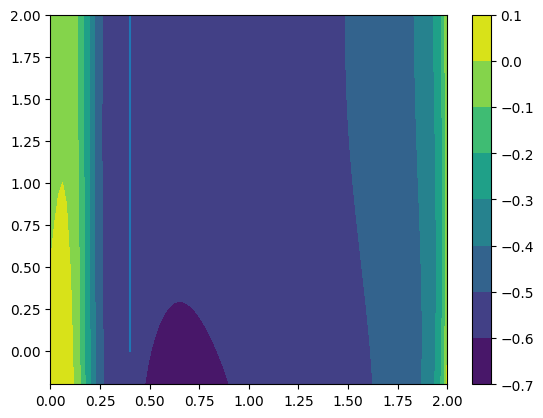

In [46]:
model_values=produce_sample(2,2,500)


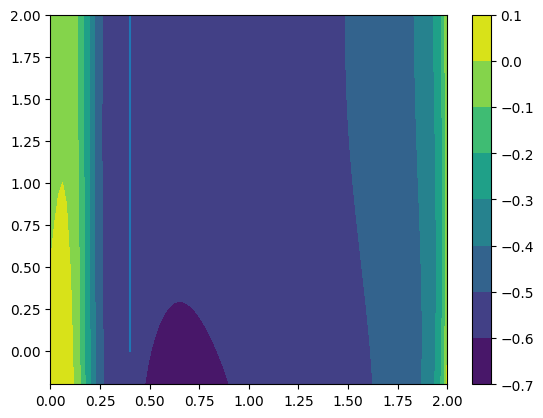

In [47]:
model_values=produce_sample(2,2,100)


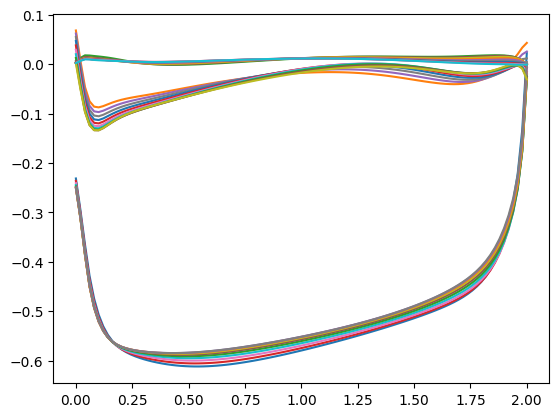

In [48]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
    for k in range(2,5):
        plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[k].tolist()))
    #plt.plot([0.4,0.4],[0.1,-0.1])

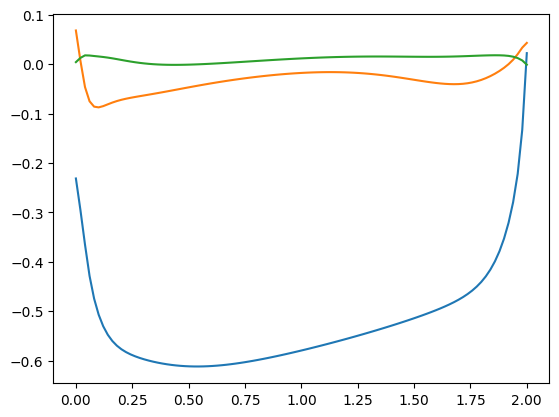

In [49]:
coords = torch.tensor([[0,i] for i in np.linspace(0,2,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
for k in range(2,5):
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[k].tolist()))
    #plt.plot([0.4,0.4],[0.1,-0.1])

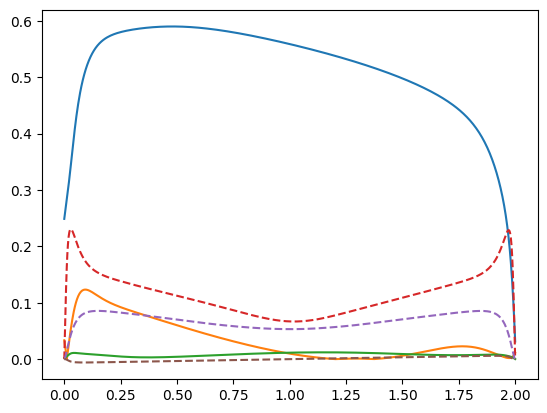

In [50]:
coords = torch.tensor([[1,i] for i in DF_Data["y"]], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
for k in range(2,5):
    plt.plot(DF_Data["y"],np.abs((np.array(model_out.transpose(0,1)[k].tolist()))))
    #plt.plot([0.4,0.4],[0.1,-0.1])
plt.plot(DF_Data["y"],DF_Data["urms"],'--')
plt.plot(DF_Data["y"],DF_Data["vrms"],'--')
plt.plot(DF_Data["y"],DF_Data["uv"],'--')

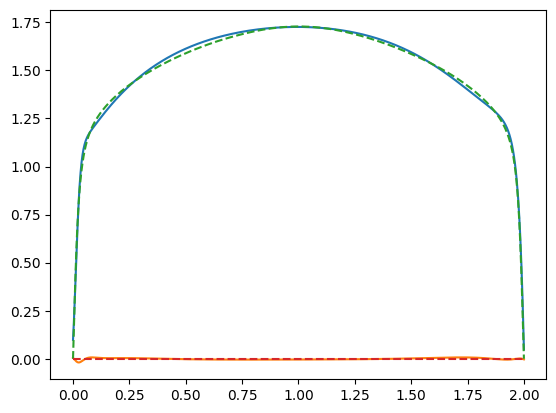

In [51]:
coords = torch.tensor([[1,i] for i in DF_Data["y"]], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
for k in range(0,2):
    plt.plot(DF_Data["y"],np.array(model_out.transpose(0,1)[k].tolist()))
    #plt.plot([0.4,0.4],[0.1,-0.1])
plt.plot(DF_Data["y"],DF_Data["U"],'--')
plt.plot(DF_Data["y"],DF_Data["V"],'--')


In [52]:
DF_Data

,x,y,U,V,urms,vrms,uv
0,0,0.000000,-7.184000e-16,-2.267000e-35,1.967500e-14,7.751400e-17,4.814100e-35
1,0,0.000031,1.286900e-03,3.593100e-26,5.187100e-04,2.314900e-07,-2.474000e-11
2,0,0.000123,5.147100e-03,6.249800e-25,2.074000e-03,3.681500e-06,-1.590600e-09
3,0,0.000278,1.158000e-02,-1.264700e-24,4.662800e-03,1.842900e-05,-1.823100e-08
4,0,0.000493,2.058300e-02,-3.911600e-24,8.281000e-03,5.731000e-05,-1.033400e-07
...,...,...,...,...,...,...,...
396,0,1.999500,2.049700e-02,7.117400e-24,8.230900e-03,5.700000e-05,1.027000e-07
397,0,1.999700,1.153100e-02,-4.540300e-25,4.634600e-03,1.832800e-05,1.812100e-08
398,0,1.999900,5.125500e-03,2.467800e-25,2.061400e-03,3.661300e-06,1.581000e-09
399,0,2.000000,1.281500e-03,4.035400e-26,5.155700e-04,2.302200e-07,2.459300e-11


In [53]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i,20] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y*H)).as_tensor
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[0].tolist()))
    plt.plot([0.3,0.3],[0.1,-0.1])

NameError: name 'H' is not defined

In [ ]:
coords = torch.tensor([[5,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))
coords = torch.tensor([[0,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))